# UT Business Process Mining Course project

The goal is to build a classifier that predicts the outcome (Pending, Denied, or Cancelled) of loan applications. After training the model, we use the SHAP explainability tool to find the best predictive features and describe the relationships between the features and the predictions.

## Importing libraries

In [1]:
# The code has been written using Python 3.10.4

# Import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
%matplotlib inline

import BucketFactory
import EncoderFactory
from sklearn.pipeline import FeatureUnion, Pipeline
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


## Read in the event log

In [2]:
# Read in the event log
log = pd.read_csv('data/Dhana Loans 2023.csv',sep=',')

In [3]:
log.head()

,Loan ID,start_time,end_time,ApplicationType,LoanGoal,RequestedAmount,Accepted,Action,CreditScore,EventID,EventOrigin,FirstWithdrawalAmount,MonthlyCost,NumberOfTerms,OfferID,OfferedAmount,Selected,Activity,Resource
0,Application_652823628,2016-01-01T09:51:15.304,2016-01-01T09:51:15.304,New credit,Existing loan takeover,20000.0,,Created,NaN,Application_652823628,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Create Application,User_1
1,Application_652823628,2016-01-01T09:51:15.352,2016-01-01T09:51:15.352,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_1582051990,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Submitted,User_1
2,Application_652823628,2016-01-01T09:52:36.413,2016-01-01T09:52:36.413,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_642383566,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Concept,User_1
3,Application_652823628,2016-01-02T10:45:22.429,2016-01-02T10:45:22.429,New credit,Existing loan takeover,20000.0,,Obtained,NaN,Workitem_1875340971,Workflow,NaN,NaN,NaN,NaN,NaN,NaN,W_Complete application,User_17
4,Application_652823628,2016-01-02T11:23:04.299,2016-01-02T11:23:04.299,New credit,Existing loan takeover,20000.0,,statechange,NaN,ApplState_99568828,Application,NaN,NaN,NaN,NaN,NaN,NaN,A_Accepted,User_52


## Change data types, impute missing values

In [4]:
# Convert timestamps to pandas datetime
log['start_time'] = pd.to_datetime(log['start_time'], infer_datetime_format=True)
log['end_time'] = pd.to_datetime(log['end_time'], infer_datetime_format=True)

In [5]:
# A look at data types
log.dtypes

Loan ID                          object
start_time               datetime64[ns]
end_time                 datetime64[ns]
ApplicationType                  object
LoanGoal                         object
RequestedAmount                 float64
Accepted                         object
Action                           object
CreditScore                     float64
EventID                          object
EventOrigin                      object
FirstWithdrawalAmount           float64
MonthlyCost                     float64
NumberOfTerms                   float64
OfferID                          object
OfferedAmount                   float64
Selected                         object
Activity                         object
Resource                         object
dtype: object

In [6]:
# Ratio of NaN values
log.isna().sum()/len(log)

Loan ID                  0.000000
start_time               0.000000
end_time                 0.000000
ApplicationType          0.000000
LoanGoal                 0.000000
RequestedAmount          0.000000
Accepted                 0.000000
Action                   0.000000
CreditScore              0.924904
EventID                  0.000000
EventOrigin              0.000000
FirstWithdrawalAmount    0.924904
MonthlyCost              0.924904
NumberOfTerms            0.924904
OfferID                  0.736003
OfferedAmount            0.924904
Selected                 0.924904
Activity                 0.000000
Resource                 0.000000
dtype: float64

In [7]:
# Remove missing values by using the max value
#log['CreditScore'] = log.groupby(['Loan ID'])['CreditScore'].transform('max')
#log['MonthlyCost'] = log.groupby(['Loan ID'])['MonthlyCost'].transform('max')
#log['NumberOfTerms'] = log.groupby(['Loan ID'])['NumberOfTerms'].transform('max')
#log['OfferedAmount'] = log.groupby(['Loan ID'])['OfferedAmount'].transform('max')
#log['Selected'] = log.groupby(['Loan ID'])['Selected'].transform('max')
#log['FirstWithdrawalAmount'] = log.groupby(['Loan ID'])['FirstWithdrawalAmount'].transform('max')

In [8]:
# Ratio of NaN values
log.isna().sum()/len(log)

Loan ID                  0.000000
start_time               0.000000
end_time                 0.000000
ApplicationType          0.000000
LoanGoal                 0.000000
RequestedAmount          0.000000
Accepted                 0.000000
Action                   0.000000
CreditScore              0.924904
EventID                  0.000000
EventOrigin              0.000000
FirstWithdrawalAmount    0.924904
MonthlyCost              0.924904
NumberOfTerms            0.924904
OfferID                  0.736003
OfferedAmount            0.924904
Selected                 0.924904
Activity                 0.000000
Resource                 0.000000
dtype: float64

## Add features

In [9]:
log['num_offers'] = log.groupby('Loan ID')['OfferID'].transform('nunique')

In [10]:
log['num_offers'].value_counts()

1    242202
2     89512
3     16587
4      5703
5      1447
6       297
7       264
8       219
9        61
Name: num_offers, dtype: int64

In [11]:
# Add case start and case end timestamps
log['case_start_timestamp'] = log.groupby('Loan ID').start_time.transform('min')
log['case_end_timestamp'] = log.groupby('Loan ID').end_time.transform('max')

# Add remaining time from case end and time elapsed from case start
log['remtime'] = (log['case_end_timestamp'] - log['end_time']).dt.total_seconds()
log['time_since_case_start'] = (log['start_time'] - log['case_start_timestamp']).dt.total_seconds()

# Add day of the week
log['start_day'] = log['start_time'].dt.dayofweek
log['end_day'] = log['end_time'].dt.dayofweek

# Add the month
log['start_month'] = log['start_time'].dt.month
log['end_month'] = log['end_time'].dt.month

In [12]:
# Function for calculating the relative time (seconds since midnight)
# Source of this function: https://stackoverflow.com/questions/54787146/get-the-time-spent-since-midnight-in-dataframe
def secSinceMidnight(datTimStr):
    tt = pd.to_datetime(datTimStr).time()
    return tt.hour * 3600 + tt.minute * 60 + tt.second

In [13]:
# Add the relative time
log['start_since_midnight'] = log['start_time'].apply(secSinceMidnight)
log['end_since_midnight'] = log['end_time'].apply(secSinceMidnight)

# Add event duraton and case duration
log['event_duration'] = (log['end_time'] - log['start_time']).dt.total_seconds()
log['case_duration'] = (log['case_end_timestamp'] - log['case_start_timestamp']).dt.total_seconds()

# Add the differences of event start times and end times
log = log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
log['time_since_last_event_start'] = log.groupby(['Loan ID'])['start_time'].diff().astype('timedelta64[s]').fillna(0)

log = log.sort_values(by=['Loan ID', 'end_time'], ascending=True)
log['time_since_last_event_end'] = log.groupby(['Loan ID'])['end_time'].diff().astype('timedelta64[s]').fillna(0)

In [14]:
# Add waiting time before event

tmp = log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
end_times = tmp.groupby(['Loan ID'])['end_time'].transform(lambda s: s.shift(1))

tmp_2 = pd.concat([tmp[['Loan ID', 'start_time']], end_times], axis=1)
tmp_2['waiting_time_before_event'] = (tmp_2['start_time'] - tmp_2['end_time']).dt.total_seconds().fillna(0)

log.sort_values(by=['Loan ID', 'start_time'], ascending=True)
tmp_2.sort_values(by=['Loan ID', 'start_time'], ascending=True)
log['waiting_time_before_event'] = tmp_2['waiting_time_before_event']

In [15]:
log[['Loan ID', 'start_time', 'end_time', 'waiting_time_before_event']] # Check that the waiting time is correct

,Loan ID,start_time,end_time,waiting_time_before_event
133682,Application_1000158214,2016-06-02 11:14:26.844,2016-06-02 11:14:26.844,0.000
133683,Application_1000158214,2016-06-02 11:14:26.885,2016-06-02 11:14:26.885,0.041
133684,Application_1000158214,2016-06-02 11:15:36.773,2016-06-02 11:15:36.773,69.888
133686,Application_1000158214,2016-06-06 09:10:07.694,2016-06-06 09:10:07.694,-399.175
133687,Application_1000158214,2016-06-06 09:12:02.402,2016-06-06 09:12:02.402,114.708
...,...,...,...,...
282352,Application_999993812,2016-10-19 11:28:11.487,2016-10-19 11:28:11.487,6.655
282353,Application_999993812,2016-10-19 13:44:29.291,2016-10-19 13:44:29.291,8177.804
282354,Application_999993812,2016-10-19 13:44:29.292,2016-10-19 13:44:29.292,0.001
282355,Application_999993812,2016-10-24 07:24:30.056,2016-10-24 07:24:30.056,409200.764


In [16]:
# Check what are unique values for the application final states
log[log.EventOrigin == "Application"].sort_values('start_time', ascending=True, kind='mergesort').groupby("Loan ID").last()["Activity"].unique()

array(['A_Pending', 'A_Cancelled', 'A_Denied'], dtype=object)

In [17]:
# Add the final state as outcome
last_application_state = log[log.EventOrigin == "Application"].sort_values('start_time', ascending=True, kind='mergesort').groupby("Loan ID").last()["Activity"]
last_application_state = pd.DataFrame(last_application_state)
last_application_state.columns = ["outcome"]

di = {'A_Pending': "Pending", 'A_Cancelled': "Cancelled", 'A_Denied':'Denied'}
last_application_state = last_application_state.replace({"outcome": di})

<AxesSubplot:ylabel='outcome'>

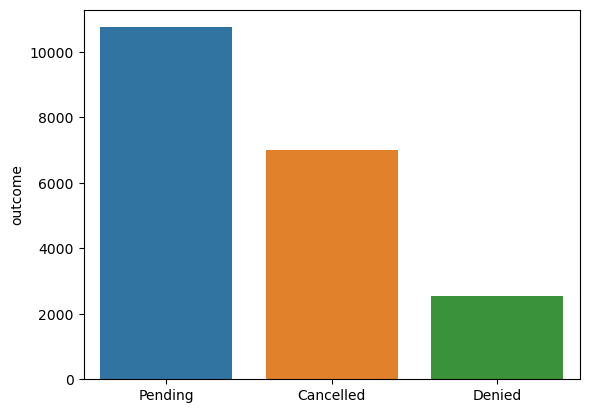

In [80]:
sns.barplot(x=last_application_state['outcome'].value_counts().index, y=last_application_state['outcome'].value_counts())

In [18]:
log = log.merge(last_application_state, left_on="Loan ID", right_index=True)

In [19]:
log.columns

Index(['Loan ID', 'start_time', 'end_time', 'ApplicationType', 'LoanGoal',
       'RequestedAmount', 'Accepted', 'Action', 'CreditScore', 'EventID',
       'EventOrigin', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms',
       'OfferID', 'OfferedAmount', 'Selected', 'Activity', 'Resource',
       'num_offers', 'case_start_timestamp', 'case_end_timestamp', 'remtime',
       'time_since_case_start', 'start_day', 'end_day', 'start_month',
       'end_month', 'start_since_midnight', 'end_since_midnight',
       'event_duration', 'case_duration', 'time_since_last_event_start',
       'time_since_last_event_end', 'waiting_time_before_event', 'outcome'],
      dtype='object')

In [20]:
log['outcome'].unique()

array(['Pending', 'Cancelled', 'Denied'], dtype=object)

In [21]:
# features
case_id_col = "Loan ID"
timestamp_col =  'case_end_timestamp'
label_col = 'outcome'
dynamic_cat_cols = ["Activity", "Resource",
                   "start_day", "end_day", "start_month", "end_month"]
static_cat_cols = ['ApplicationType', 'LoanGoal', 'num_offers']
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'CreditScore', 'time_since_last_event_end',
                    'time_since_last_event_start', 'waiting_time_before_event', 'event_duration',
                    'start_since_midnight', 'end_since_midnight']
static_num_cols = ['RequestedAmount', 'case_duration']

static_cols = static_cat_cols + static_num_cols + [case_id_col, timestamp_col]
dynamic_cols = dynamic_cat_cols + dynamic_num_cols + [timestamp_col]
cat_cols = dynamic_cat_cols + static_cat_cols

In [22]:
# Create the log schema
log_schema = {'case_id_col': case_id_col,
              'timestamp_col': timestamp_col,
              'activity_col': 'Activity',
              'label': 'outcome',
              'static_cat_cols': static_cat_cols,
              'static_num_cols': static_num_cols,
              'dynamic_cat_cols': dynamic_cat_cols,
              'dynamic_num_cols': dynamic_num_cols, 
             }

In [23]:
# Not we leave out all events regarding Application Cancelled/Denied/Pending and Offer Refused/Accepted/Cancelled because that is basically our label
# We want to know how the preceeding events can predict the end events/outcome
outcome_events = ['O_Cancelled', 'O_Refused', 'O_Accepted', 'A_Pending', 'A_Denied', 'A_Cancelled']
log = log[~log['Activity'].isin(outcome_events)]

In [24]:
log = log.replace(r'^\s*$', np.nan, regex=True) # Replace blanck values / spaces with np.nan

In [25]:
# impute missing values
log_final = log.copy()
grouped = log_final.sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col)
for col in static_cols + dynamic_cols:
    log_final[col] = grouped[col].transform(lambda grp: grp.fillna(method='ffill')) # First ffill, then bfill
    log_final[col] = grouped[col].transform(lambda grp: grp.fillna(method='bfill'))

log_final[cat_cols] = log_final[cat_cols].fillna('missing')
log_final = log_final.fillna(0)

In [26]:
log_final.to_csv('./data/processed_outcome__log.csv', index=False)

In [27]:
log_final # We only imputed the missing values for the features we are using in the model

,Loan ID,start_time,end_time,ApplicationType,LoanGoal,RequestedAmount,Accepted,Action,CreditScore,EventID,...,start_month,end_month,start_since_midnight,end_since_midnight,event_duration,case_duration,time_since_last_event_start,time_since_last_event_end,waiting_time_before_event,outcome
133682,Application_1000158214,2016-06-02 11:14:26.844,2016-06-02 11:14:26.844,New credit,Home improvement,12500.0,0,Created,929.0,Application_1000158214,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.000,Pending
133683,Application_1000158214,2016-06-02 11:14:26.885,2016-06-02 11:14:26.885,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_277536765,...,6,6,40466,40466,0.0,694054.434,0.0,0.0,0.041,Pending
133684,Application_1000158214,2016-06-02 11:15:36.773,2016-06-02 11:15:36.773,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_1547990892,...,6,6,40536,40536,0.0,694054.434,69.0,69.0,69.888,Pending
133686,Application_1000158214,2016-06-06 09:10:07.694,2016-06-06 09:10:07.694,New credit,Home improvement,12500.0,0,statechange,929.0,ApplState_226397461,...,6,6,33007,33007,0.0,694054.434,471.0,338070.0,-399.175,Pending
133687,Application_1000158214,2016-06-06 09:12:02.402,2016-06-06 09:12:02.402,New credit,Home improvement,12500.0,true,Created,929.0,Offer_927137349,...,6,6,33122,33122,0.0,694054.434,114.0,114.0,114.708,Pending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282350,Application_999993812,2016-10-19 11:28:03.952,2016-10-19 11:28:03.952,New credit,Caravan / Camper,30000.0,0,Obtained,0.0,Workitem_2064517246,...,10,10,41283,41283,0.0,1528045.960,769251.0,769251.0,769251.526,Pending
282351,Application_999993812,2016-10-19 11:28:04.832,2016-10-19 11:28:04.832,New credit,Caravan / Camper,30000.0,0,statechange,0.0,ApplState_306039057,...,10,10,41284,41284,0.0,1528045.960,0.0,0.0,0.880,Pending
282352,Application_999993812,2016-10-19 11:28:11.487,2016-10-19 11:28:11.487,New credit,Caravan / Camper,30000.0,0,statechange,0.0,OfferState_1258740957,...,10,10,41291,41291,0.0,1528045.960,6.0,6.0,6.655,Pending
282353,Application_999993812,2016-10-19 13:44:29.291,2016-10-19 13:44:29.291,New credit,Caravan / Camper,30000.0,0,Obtained,0.0,Workitem_1598850294,...,10,10,49469,49469,0.0,1528045.960,8177.0,8177.0,8177.804,Pending


In [28]:
log_final.isna().sum()

Loan ID                        0
start_time                     0
end_time                       0
ApplicationType                0
LoanGoal                       0
RequestedAmount                0
Accepted                       0
Action                         0
CreditScore                    0
EventID                        0
EventOrigin                    0
FirstWithdrawalAmount          0
MonthlyCost                    0
NumberOfTerms                  0
OfferID                        0
OfferedAmount                  0
Selected                       0
Activity                       0
Resource                       0
num_offers                     0
case_start_timestamp           0
case_end_timestamp             0
remtime                        0
time_since_case_start          0
start_day                      0
end_day                        0
start_month                    0
end_month                      0
start_since_midnight           0
end_since_midnight             0
event_dura

## Train-Test split

In [29]:
# This function is from practice materials
# Split into training and test

def temporal_split(data, log_schema, train_ratio):  
    # Split into train and test using temporal split and discard events that overlap the periods
    data = data.sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    grouped = data.groupby(log_schema.get('case_id_col'))
    start_timestamps = grouped[log_schema.get('timestamp_col')].min().reset_index()
    start_timestamps = start_timestamps.sort_values(log_schema.get('timestamp_col'), ascending=True, kind='mergesort')
    train_ids = list(start_timestamps[log_schema.get('case_id_col')])[:int(train_ratio*len(start_timestamps))]
    train = data[data[log_schema.get('case_id_col')].isin(train_ids)].sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    test = data[~data[log_schema.get('case_id_col')].isin(train_ids)].sort_values([log_schema.get('timestamp_col'), log_schema.get('activity_col')], ascending=True, kind='mergesort')
    split_ts = test[log_schema.get('timestamp_col')].min()
    train = train[train[log_schema.get('timestamp_col')] < split_ts]
    return (train, test)

In [30]:
# Do the temporal split into train and test set
train, test = temporal_split(log_final, log_schema, 0.8)
len(train), len(test)

(247025, 62218)

## Prefix data

In [31]:
# Determine min and max (truncated) prefix lengths
# Function is from practice materials
min_prefix_length = 1
def get_pos_case_length_quantile(data, log_schema, quantile=0.90):
    return int(np.ceil(data.groupby(log_schema.get('case_id_col')).size().quantile(quantile)))
max_prefix_length = min(40, get_pos_case_length_quantile(log, log_schema, 0.90))

In [32]:
# Function is from practice materials
def generate_prefix_data(data, min_length, max_length, log_schema, gap=1):
    # generate prefix data (each possible prefix becomes a trace)
    data['case_length'] = data.groupby(log_schema.get('case_id_col'))[log_schema.get('activity_col')].transform(len)

    dt_prefixes = data[data['case_length'] >= min_length].groupby(log_schema.get('case_id_col')).head(min_length)
    dt_prefixes["prefix_nr"] = 1
    dt_prefixes["orig_case_id"] = dt_prefixes[log_schema.get('case_id_col')]
    for nr_events in range(min_length+gap, max_length+1, gap):
        tmp = data[data['case_length'] >= nr_events].groupby(log_schema.get('case_id_col')).head(nr_events)
        tmp["orig_case_id"] = tmp[log_schema.get('case_id_col')]
        tmp[log_schema.get('case_id_col')] = tmp[log_schema.get('case_id_col')].apply(lambda x: "%s_%s"%(x, nr_events))
        tmp["prefix_nr"] = nr_events
        dt_prefixes = pd.concat([dt_prefixes, tmp], axis=0)

    dt_prefixes['case_length'] = dt_prefixes['case_length'].apply(lambda x: min(max_length, x))

    return dt_prefixes

In [33]:
dt_train_prefixes = generate_prefix_data(train, min_prefix_length, max_prefix_length, log_schema)
dt_test_prefixes = generate_prefix_data(test, min_prefix_length, max_prefix_length, log_schema)

In [34]:
len(dt_train_prefixes)

2058799

In [35]:
print(dt_train_prefixes.prefix_nr.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


## Single Bucketing

For simplicity, we only use single bucketing here.

In [36]:
random_state = 22
bucketer_args = {'case_id_col': log_schema.get('case_id_col'), 
                 'cat_cols':[log_schema.get('activity_col')], 
                 'num_cols':[], 
                 'random_state':random_state}

In [37]:
bucket_method = 'single'
bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)
bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
bucket_assignments_test = bucketer.predict(dt_test_prefixes)

In [38]:
print('Train assignments:')
bucket_assignments_train
print(pd.DataFrame(bucket_assignments_train, columns=['bucket']).bucket.value_counts())
print('Test assignments:')
bucket_assignments_test
print(pd.DataFrame(bucket_assignments_test, columns=['bucket']).bucket.value_counts())

Train assignments:
1    242088
Name: bucket, dtype: int64
Test assignments:
1    60771
Name: bucket, dtype: int64


In [39]:
bucketer.n_states

1

In [40]:
bucket_indexes = dt_train_prefixes.groupby(log_schema.get('case_id_col')).first().index
bucket_indexes = bucket_indexes[bucket_assignments_train == 1]
print(bucket_indexes)

Index(['Application_1000158214', 'Application_1000158214_10',
       'Application_1000158214_11', 'Application_1000158214_12',
       'Application_1000158214_13', 'Application_1000158214_2',
       'Application_1000158214_3', 'Application_1000158214_4',
       'Application_1000158214_5', 'Application_1000158214_6',
       ...
       'Application_999993812_14', 'Application_999993812_15',
       'Application_999993812_2', 'Application_999993812_3',
       'Application_999993812_4', 'Application_999993812_5',
       'Application_999993812_6', 'Application_999993812_7',
       'Application_999993812_8', 'Application_999993812_9'],
      dtype='object', name='Loan ID', length=242088)


In [41]:
def get_label(data):
    y = data.groupby(log_schema.get('case_id_col')).first()[log_schema.get('label')] # one row per case
    return y

In [42]:
di = {'Pending': "0", 'Denied':'1','Cancelled': "2"} # Factorize manually to ensure that train_y and test_y are factorized the same

In [43]:
bucket_data = dt_train_prefixes[dt_train_prefixes[log_schema.get('case_id_col')].isin(bucket_indexes)]
train_y = get_label(bucket_data)

In [44]:
from tensorflow.keras import utils as np_utils
train_y = np_utils.to_categorical(train_y.map(di)) # One-hot-encode

In [45]:
train_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [46]:
bucket_indexes = dt_test_prefixes.groupby(log_schema.get('case_id_col')).first().index
bucket_indexes = bucket_indexes[bucket_assignments_test == 1]
print(bucket_indexes)
bucket_data_test = dt_test_prefixes[dt_test_prefixes[log_schema.get('case_id_col')].isin(bucket_indexes)]
test_y = get_label(bucket_data_test)
test_y = np_utils.to_categorical(test_y.map(di)) # One-hot-encode

Index(['Application_1000386745', 'Application_1000386745_10',
       'Application_1000386745_11', 'Application_1000386745_12',
       'Application_1000386745_13', 'Application_1000386745_14',
       'Application_1000386745_15', 'Application_1000386745_16',
       'Application_1000386745_17', 'Application_1000386745_18',
       ...
       'Application_998917442', 'Application_998917442_10',
       'Application_998917442_2', 'Application_998917442_3',
       'Application_998917442_4', 'Application_998917442_5',
       'Application_998917442_6', 'Application_998917442_7',
       'Application_998917442_8', 'Application_998917442_9'],
      dtype='object', name='Loan ID', length=60771)


In [47]:
test_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Pipeline: create encodings and train XGBoost Classifier to predict case outcome

In [48]:
methods = ['agg'] # Aggregation encoding
feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **log_schema)) for method in methods])
feature_combiner

FeatureUnion(transformer_list=[('agg',
                                <transformers.AggregateTransformer.AggregateTransformer object at 0x0000013288285420>)])

In [49]:
model = xgb.XGBClassifier(n_estimators=400, learning_rate=0.3, n_jobs=2, random_state=0) # Ideally, CV and hyperparam optimization should be added

In [50]:
pipeline = Pipeline([('encoder', feature_combiner), ('xgb', model)])
pipeline.fit(bucket_data, train_y)

Pipeline(steps=[('encoder',
                 FeatureUnion(transformer_list=[('agg',
                                                 <transformers.AggregateTransformer.AggregateTransformer object at 0x0000013288285420>)])),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               fea...None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=400, n_jobs=2, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

In [51]:
preds = pipeline.predict(bucket_data_test)
print(preds)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [52]:
acc_xgb = np.sum(np.sum(preds == test_y, axis=1)==3) / len(preds)*100
print("Accuracy in percentages: ", acc_xgb)

Accuracy in percentages:  86.54950552072535


In [53]:
from sklearn.metrics import classification_report
print(classification_report(test_y, preds))

# 0 is pending, 1 is denied, 2 is cancelled

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     36412
           1       0.74      0.70      0.72      8431
           2       0.86      0.79      0.82     15928

   micro avg       0.92      0.88      0.90     60771
   macro avg       0.86      0.81      0.84     60771
weighted avg       0.92      0.88      0.90     60771
 samples avg       0.87      0.88      0.87     60771



c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


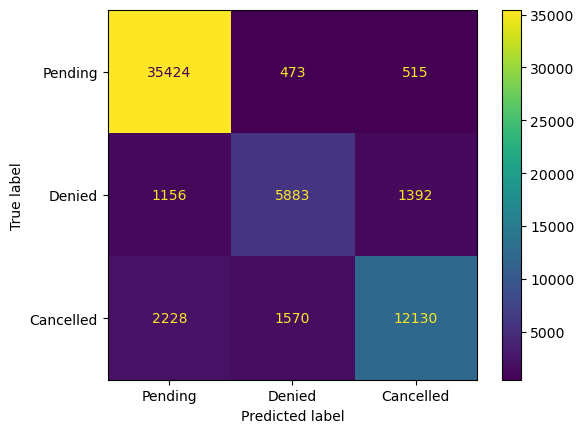

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_y.argmax(axis=1), preds.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Pending', 'Denied', 'Cancelled'])
disp.plot()
plt.show()

In [56]:
print(train_y.sum(axis=0))

[149087.  30180.  62821.]


In [57]:
print(test_y.sum(axis=0))

[36412.  8431. 15928.]


In [58]:
print(preds.sum(axis=0))

[35085.  8001. 14625.]


## Plot feature importances

In [59]:
feature_names = pipeline.named_steps["encoder"].get_feature_names()
feature_names

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['agg__start_day',
 'agg__end_day',
 'agg__start_month',
 'agg__end_month',
 'agg__Activity_A_Accepted',
 'agg__Activity_A_Complete',
 'agg__Activity_A_Concept',
 'agg__Activity_A_Create Application',
 'agg__Activity_A_Incomplete',
 'agg__Activity_A_Submitted',
 'agg__Activity_A_Validating',
 'agg__Activity_O_Create Offer',
 'agg__Activity_O_Created',
 'agg__Activity_O_Returned',
 'agg__Activity_O_Sent (mail and online)',
 'agg__Activity_O_Sent (online only)',
 'agg__Activity_W_Assess potential fraud',
 'agg__Activity_W_Call after offers',
 'agg__Activity_W_Call incomplete files',
 'agg__Activity_W_Complete application',
 'agg__Activity_W_Handle leads',
 'agg__Activity_W_Shortened completion',
 'agg__Activity_W_Validate application',
 'agg__Resource_User_1',
 'agg__Resource_User_10',
 'agg__Resource_User_100',
 'agg__Resource_User_101',
 'agg__Resource_User_102',
 'agg__Resource_User_103',
 'agg__Resource_User_104',
 'agg__Resource_User_106',
 'agg__Resource_User_107',
 'agg__Resource_

In [82]:
len(feature_names)

212

In [60]:
importances = pipeline.named_steps["xgb"].feature_importances_.flatten()

In [61]:
# Zip coefficients and names together and make a DataFrame
# Source of this code: https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
zipped = zip(feature_names, importances)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

In [62]:
df

,feature,value,abs_value,colors
177,agg__CreditScore_sum,0.695916,0.695916,green
10,agg__Activity_A_Validating,0.056486,0.056486,green
11,agg__Activity_O_Create Offer,0.043756,0.043756,green
12,agg__Activity_O_Created,0.020338,0.020338,green
8,agg__Activity_A_Incomplete,0.013455,0.013455,green
...,...,...,...,...
15,agg__Activity_O_Sent (online only),0.000000,0.000000,red
69,agg__Resource_User_146,0.000000,0.000000,red
178,agg__CreditScore_mean,0.000000,0.000000,red
179,agg__CreditScore_std,0.000000,0.000000,red


C:\Users\kohvk\AppData\Local\Temp\ipykernel_13224\2393719833.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)


Text(0, 0.5, 'Feature Name')

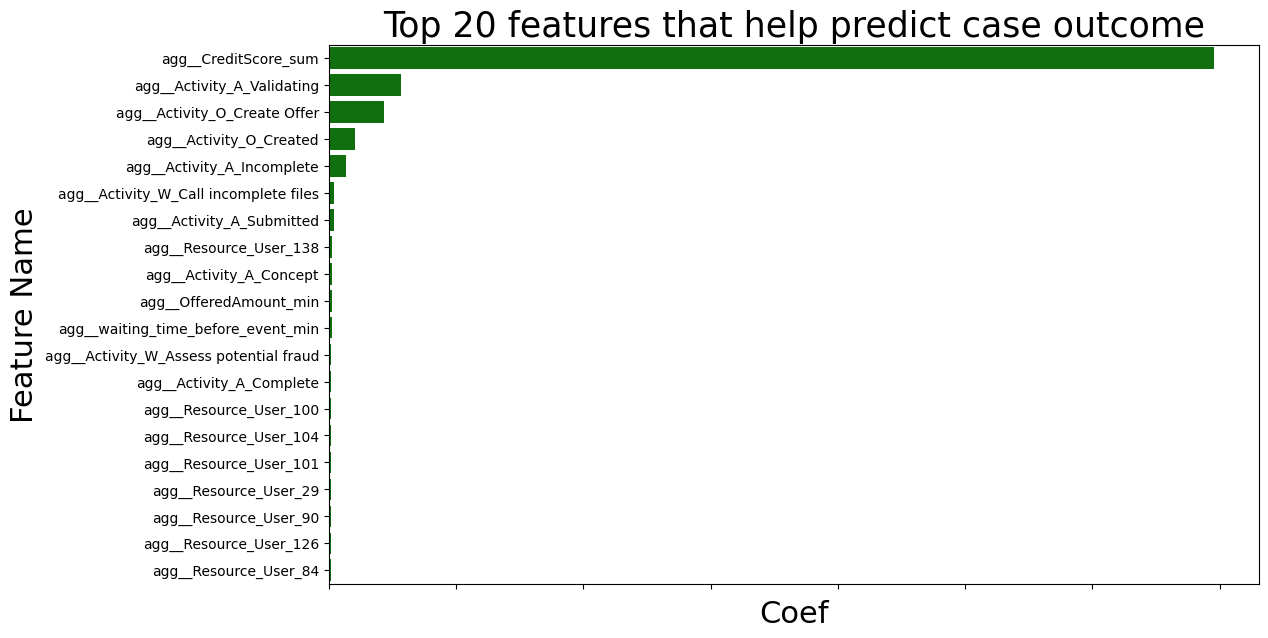

In [63]:
# Plot feature importances
# Source of this code: https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(y="feature",
            x="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 features that help predict case outcome", fontsize=25)
ax.set_xlabel("Coef", fontsize=22)
ax.set_ylabel("Feature Name", fontsize=22)

## SHAP

In [64]:
import shap

c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\kohvk\anaconda3\envs\atm_2022\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [113]:
shap.initjs()

In [65]:
encodings = feature_combiner.fit_transform(bucket_data, train_y)

In [81]:
encodings.shape

(242088, 212)

In [115]:
encodings_test.shape

(60771, 212)

In [66]:
explainer = shap.TreeExplainer(pipeline.named_steps["xgb"])
shap_values = explainer.shap_values(encodings)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [67]:
shap_obj = explainer(encodings)

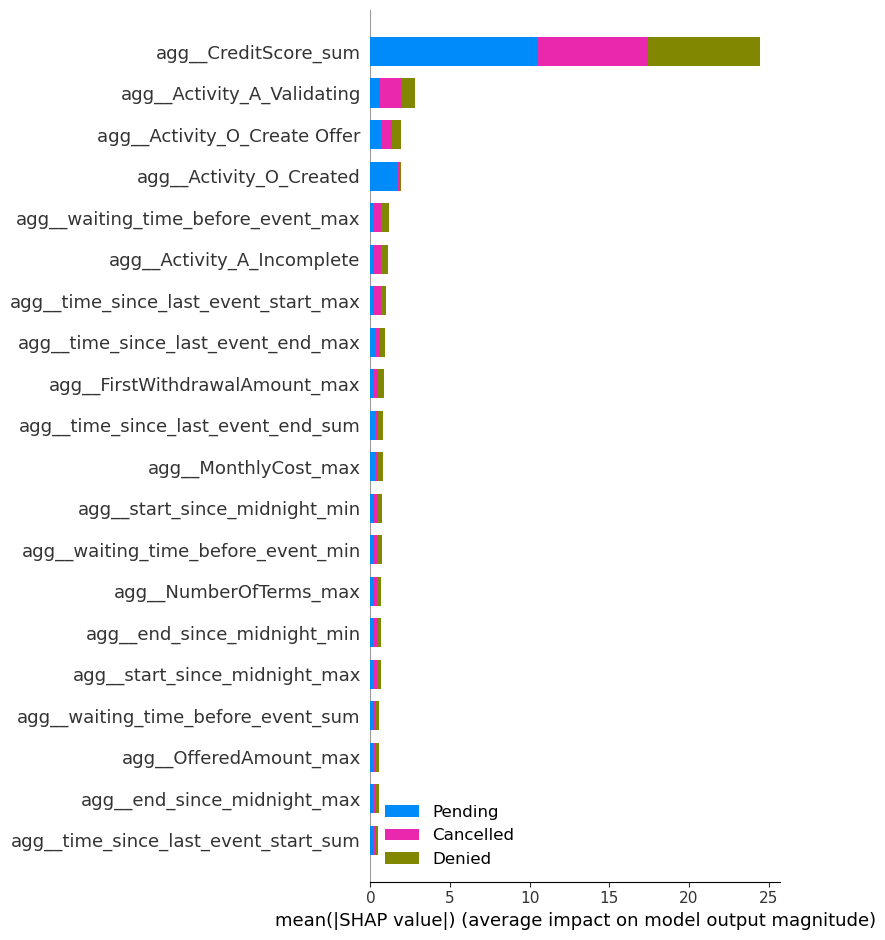

In [68]:
# 0 is pending, 1 is denied, 2 is cancelled
class_names = ['Pending', 'Denied','Cancelled']
shap.summary_plot(shap_values=shap_values, features=encodings, feature_names=feature_names,plot_type="bar", class_names=class_names)

In [123]:
exp_pending = shap.Explanation(shap_obj.values[:,:,0], 
                  shap_obj.base_values[:,0], 
                  data=encodings, 
                  feature_names=feature_names)

In [124]:
exp_denied = shap.Explanation(shap_obj.values[:,:,1], 
                  shap_obj.base_values[:,1], 
                  data=encodings, 
                  feature_names=feature_names)

In [125]:
exp_cancelled = shap.Explanation(shap_obj.values[:,:,2], 
                  shap_obj.base_values[:,2], 
                  data=encodings, 
                  feature_names=feature_names)

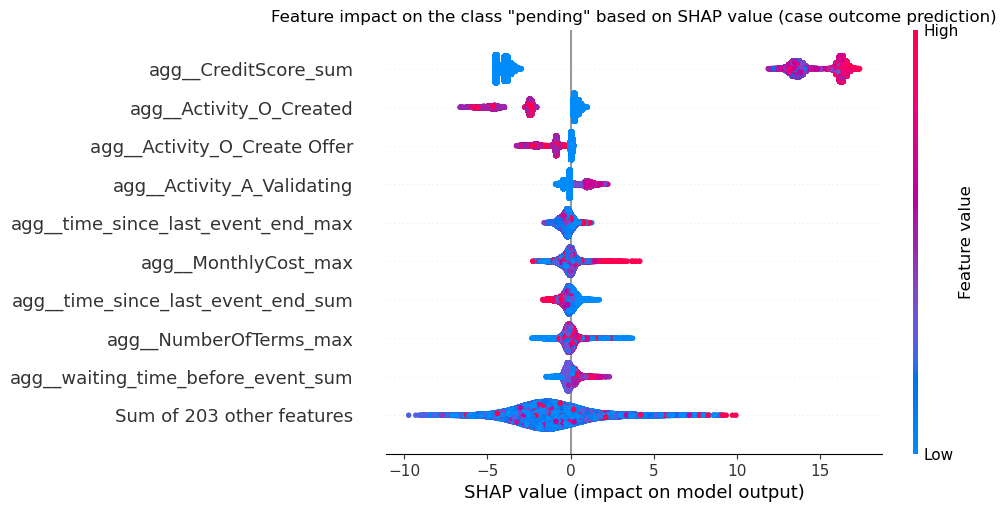

In [127]:
shap.plots.beeswarm(exp_pending, show=False)
ax = plt.gca()
ax.set_title('Feature impact on the class "pending" based on SHAP value (case outcome prediction)')
plt.show()

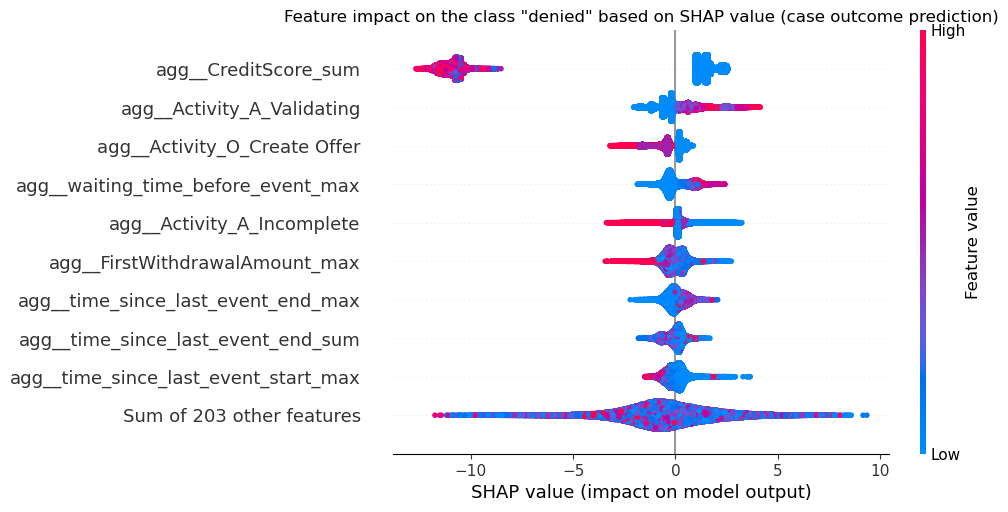

In [128]:
shap.plots.beeswarm(exp_denied, show=False)
ax = plt.gca()
ax.set_title('Feature impact on the class "denied" based on SHAP value (case outcome prediction)')
plt.show()

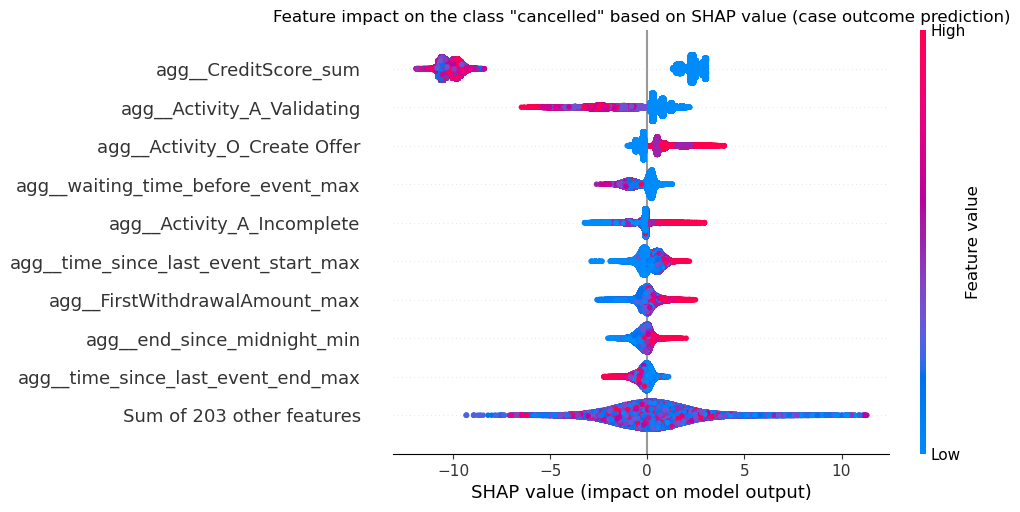

In [129]:
shap.plots.beeswarm(exp_cancelled, show=False)
ax = plt.gca()
ax.set_title('Feature impact on the class "cancelled" based on SHAP value (case outcome prediction)')
plt.show()

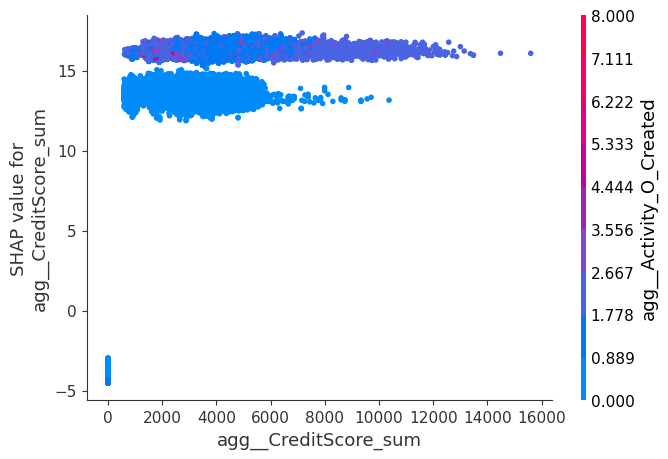

In [139]:
shap.dependence_plot("rank(0)", shap_values=shap_obj.values[:,:,0], features=encodings, feature_names=feature_names) # Pending class

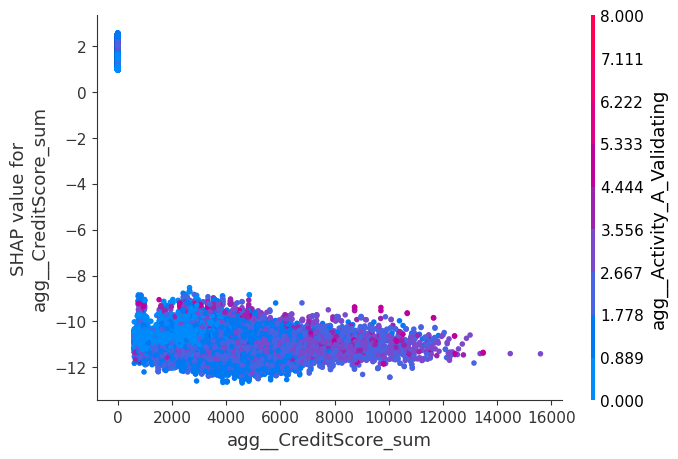

In [146]:
shap.dependence_plot("rank(0)", shap_values=shap_obj.values[:,:,1], features=encodings, feature_names=feature_names) # Denied class

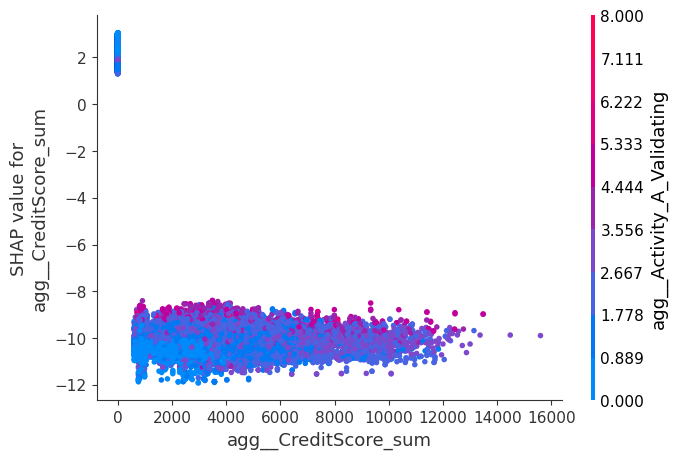

In [148]:
shap.dependence_plot("rank(0)", shap_values=shap_obj.values[:,:,2], features=encodings, feature_names=feature_names) # Cancelled class

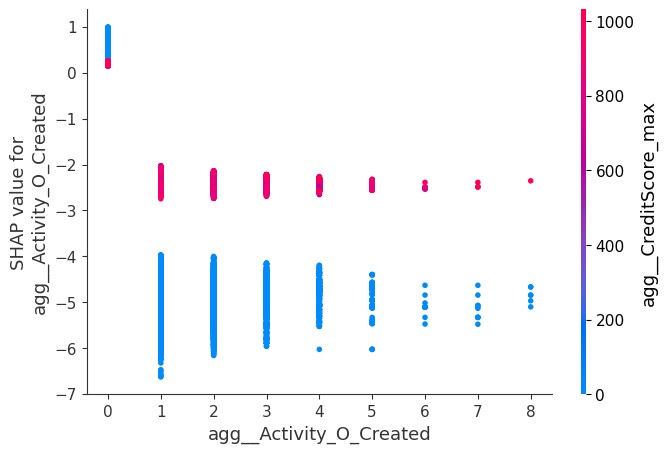

In [140]:
shap.dependence_plot("rank(1)", shap_values=shap_obj.values[:,:,0], features=encodings, feature_names=feature_names) # Pending class

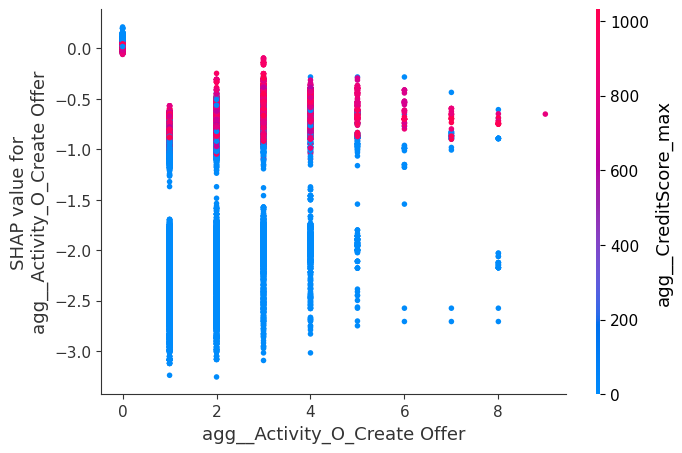

In [141]:
shap.dependence_plot("rank(2)", shap_values=shap_obj.values[:,:,0], features=encodings, feature_names=feature_names) # Pending class

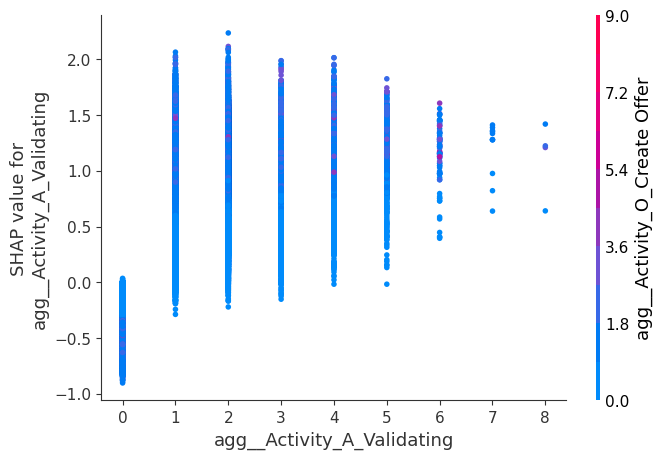

In [142]:
shap.dependence_plot("rank(3)", shap_values=shap_obj.values[:,:,0], features=encodings, feature_names=feature_names) # Pending class

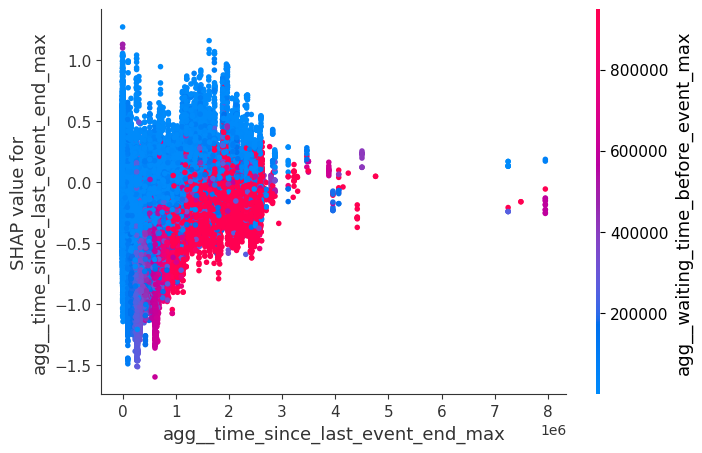

In [143]:
shap.dependence_plot("rank(4)", shap_values=shap_obj.values[:,:,0], features=encodings, feature_names=feature_names) # Pending class

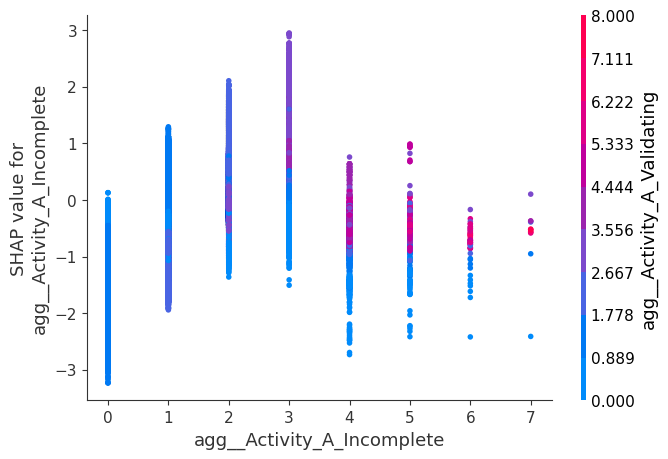

In [145]:
shap.dependence_plot("rank(4)", shap_values=shap_obj.values[:,:,2], features=encodings, feature_names=feature_names) # Cancelled class

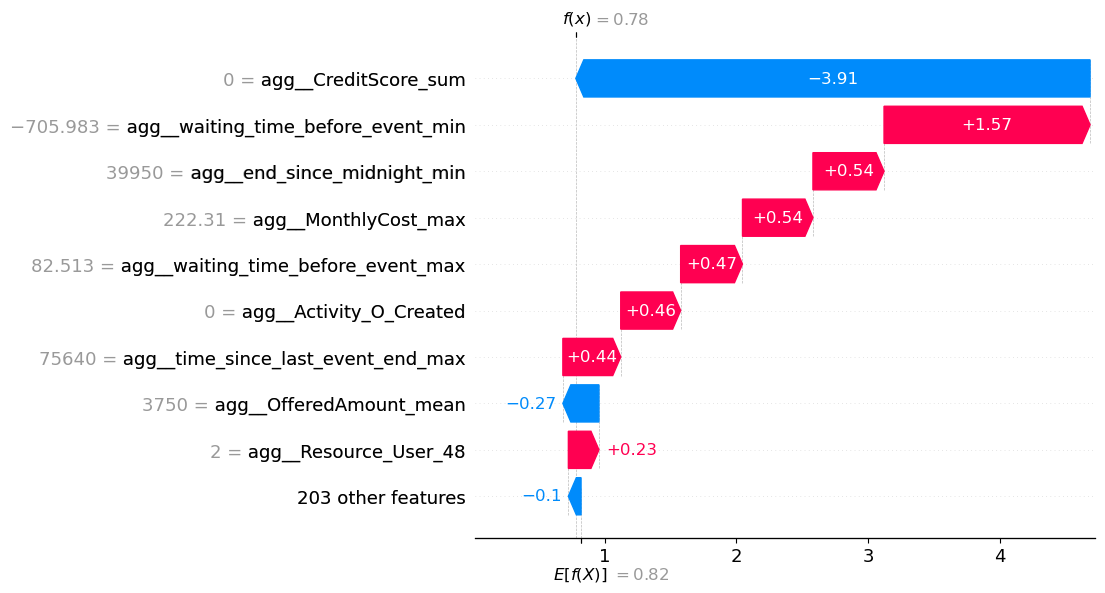

In [131]:
shap.plots.waterfall(exp_pending[100])

In [150]:
train_y[100] # It was indeed pending.

array([1., 0., 0.], dtype=float32)

### SHAP on the test set

In [114]:
encodings_test = feature_combiner.fit_transform(bucket_data_test, test_y)

In [116]:
encodings_test.shape

(60771, 212)

In [117]:
shap_values_test = explainer.shap_values(encodings_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


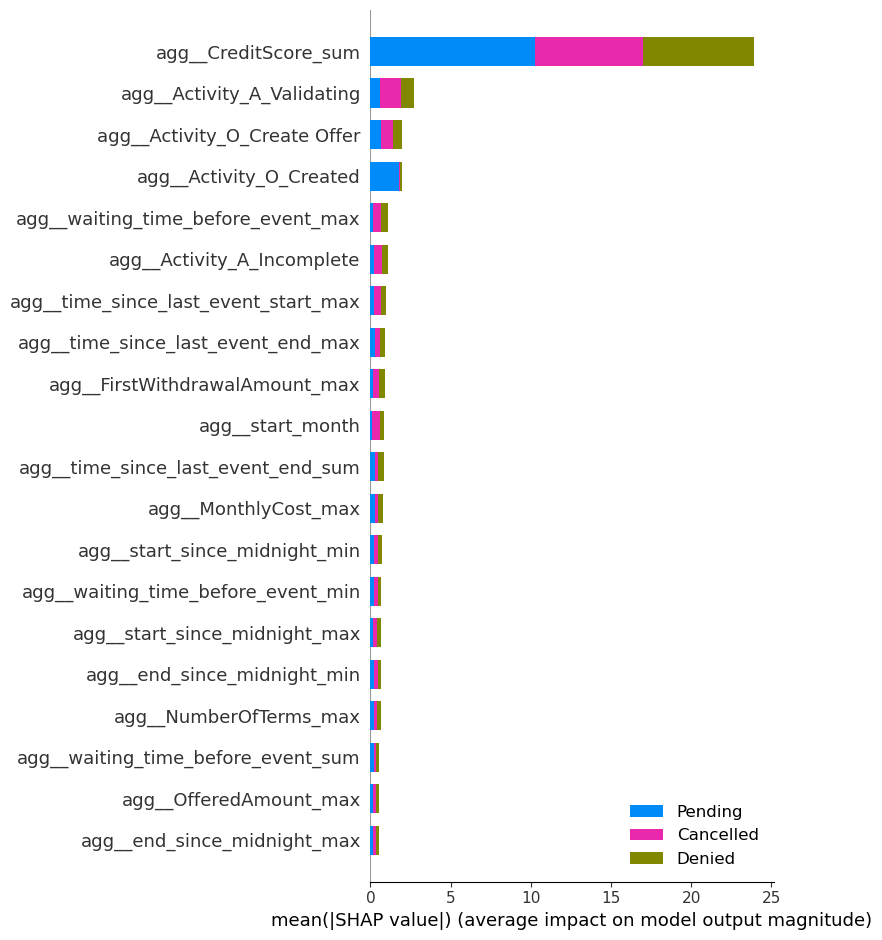

In [130]:
class_names = ['Pending', 'Denied','Cancelled']
shap.summary_plot(shap_values=shap_values_test, features=encodings_test, feature_names=feature_names,plot_type="bar", class_names=class_names)

# As we can see, the mean SHAP values on test seda are very similar, top ranking of features is the same.